Part II: Implement SARSA [30 pts]

Referencing code of part 1 for making the environment

In [46]:
!pip install gymnasium

In [47]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [62]:

class GridWorld(gym.Env):
    def __init__(self):
        super().__init__()

        # Grid dimensions
        self.grid_size = 6
        self.state_space = self.grid_size * self.grid_size

        # Action space
        self.action_space = spaces.Discrete(5)  # 0: Up, 1: Down, 2: Right, 3: Left, 4: Diagonal Down Right
        self.action_names = ["Up", "Down", "Right", "Left", "Diagonal Down Right"]

        # Observation space (6x6 grid positions) Flat index of (row, col)
        self.observation_space = spaces.Discrete(self.state_space)

        # Reward matrix
        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[1, 4] = 5
        self.rewards[2, 5] = 15
        self.rewards[3, 4] = 10
        self.rewards[1, 3] = 10
        self.rewards[5, 1] = 25
        self.rewards[3, 2] = 20
        self.rewards[5, 5] = 100

        # Initial state
        self.state = (0, 0)
        # Initialize the total reward
        self.total_reward = 0

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))

        # Create grid
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(np.arange(0, self.grid_size, 1))
        ax.set_yticks(np.arange(0, self.grid_size, 1))
        ax.grid(True, which='both', color='black', linewidth=2)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        # Load reward images
        reward_images = {
            5: "images/reward5.png",
            10: "images/reward10.png",
            15: "images/reward15.png",
            20: "images/reward20.png",
            25: "images/reward25.png",
            100: "images/reward100.png",
        }

        # Image size
        image_size = 0.2
        image_width = 35
        image_height = 35

        # Plot rewards and agent
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                reward = self.rewards[i, j]
                if reward != 0:
                    reward_image = reward_images.get(reward)
                    if reward_image:
                        try:
                            img = Image.open(reward_image)
                            img = img.resize((image_width, image_height))
                            imagebox = OffsetImage(img)
                            ab = AnnotationBbox(imagebox, (j + 0.5, self.grid_size - 1 - i + 0.5), frameon=False, boxcoords="data")
                            ax.add_artist(ab)
                        except FileNotFoundError:
                            print(f"Warning: Image for reward {reward} not found.")
        agent_row, agent_col = self.state
        try:
            agent_img = Image.open("images/agent.png")
            agent_img = agent_img.convert("RGBA")
            agent_imagebox = OffsetImage(agent_img, zoom=image_size)
            agent_ab = AnnotationBbox(agent_imagebox, (agent_col + 0.5, self.grid_size - 1 - agent_row + 0.5), frameon=False, boxcoords="data")
            ax.add_artist(agent_ab)
        except FileNotFoundError:
            print("Warning: 'agent.png' image not found.")

        plt.show()

    def step(self, action):
        row, col = self.state
        old_state = self.state

        # Calculate new position based on action
        if action == 0:  # Up
            row = max(0, row - 1)
        elif action == 1:  # Down
            row = min(self.grid_size - 1, row + 1)
        elif action == 2:  # Right
            col = min(self.grid_size - 1, col + 1)
        elif action == 3:  # Left
            col = max(0, col - 1)
        elif action == 4:  # Diagonal Down Right
            if row < self.grid_size - 1 and col < self.grid_size - 1:
                row = row + 1
                col = col + 1

        self.state = (row, col)

        # If the state didn't change, no further processing for rewards.
        if self.state == old_state:
            return self.state, self.total_reward, False, False, {}

        # Get reward for the new position
        reward_collected = self.rewards[row, col]

        # If there's a reward, add it , after that make reward 0 for that cell
        if reward_collected != 0:
            self.total_reward += reward_collected
            self.rewards[row, col] = 0
        else:
            # Apply penalty if no reward at the new position
            self.total_reward -= 1

        # Check if the goal state is reached
        done = False
        if self.state == (5, 5):
            done = True  # Goal reached

        return self.state, self.total_reward, done, False, {}

    def reset(self):
        self.state = (0, 0)
        self.total_reward = 0
        return self.state



Implementing SARSA

In [63]:
import random

In [64]:
# Epsilon-greedy function
def epsilon_greedy(Q, state, epsilon, num_actions):
    if random.uniform(0, 1) < epsilon:
        # Exploration: Choose a random action
        return random.randint(0, num_actions - 1)
    else:
        # Exploitation: Choose the action with the highest Q-value
        return np.argmax(Q[state[0] * 6 + state[1]])  # Convert 2D state to 1D


# SARSA approach implementation
def sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay):
    # Initialize Q-table with random small values
    Q = np.random.uniform(low=0.00, high=0.02, size=(env.state_space, env.action_space.n))
    #zero initialize
    #Q = np.zeros((env.state_space, env.action_space.n))
    # Ensure terminal state (5,5) has Q-values of 0
    Q[5 * 6 + 5, :] = 0

    total_rewards = []
    epsilon_values = []

    # Track initial Q-table for later printing
    initial_Q = Q.copy()

    for episode in range(episodes):
        state = env.reset()
        action = epsilon_greedy(Q, state, epsilon, env.action_space.n)

        total_reward = 0
        done = False

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon, env.action_space.n)

            # Update Q-value using SARSA formula, except for terminal state
            if next_state != (5, 5):
                Q[state[0] * 6 + state[1], action] += alpha * (reward + discount * Q[next_state[0] * 6 + next_state[1], next_action] - Q[state[0] * 6 + state[1], action])

            state, action = next_state, next_action
            total_reward += reward

        #ensure terminal state Q-value is 0
        Q[5 * 6 + 5, :] = 0

        total_rewards.append(total_reward)

        # Epsilon decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)

    return Q, initial_Q, total_rewards, epsilon_values



Running SARSA

In [65]:
import pandas as pd

Initial Q-table:
                    Up      Down     Right      Left  Diagonal Down Right
State (0, 0)  0.014610  0.006227  0.010657  0.018066             0.010982
State (0, 1)  0.010515  0.017947  0.005812  0.015147             0.015163
State (0, 2)  0.010985  0.015468  0.005618  0.018401             0.008483
State (0, 3)  0.012078  0.011838  0.015141  0.014640             0.008001
State (0, 4)  0.012313  0.001251  0.010191  0.000986             0.010081
State (0, 5)  0.007834  0.003697  0.002271  0.008327             0.014956
State (1, 0)  0.009155  0.002690  0.016180  0.006265             0.000989
State (1, 1)  0.000469  0.006842  0.006267  0.007466             0.010605
State (1, 2)  0.019330  0.012801  0.019803  0.008997             0.016874
State (1, 3)  0.013448  0.017772  0.018781  0.013214             0.016231
State (1, 4)  0.004281  0.003405  0.016322  0.008576             0.010308
State (1, 5)  0.006341  0.007966  0.019930  0.004364             0.009111
State (2, 0)  0.00582

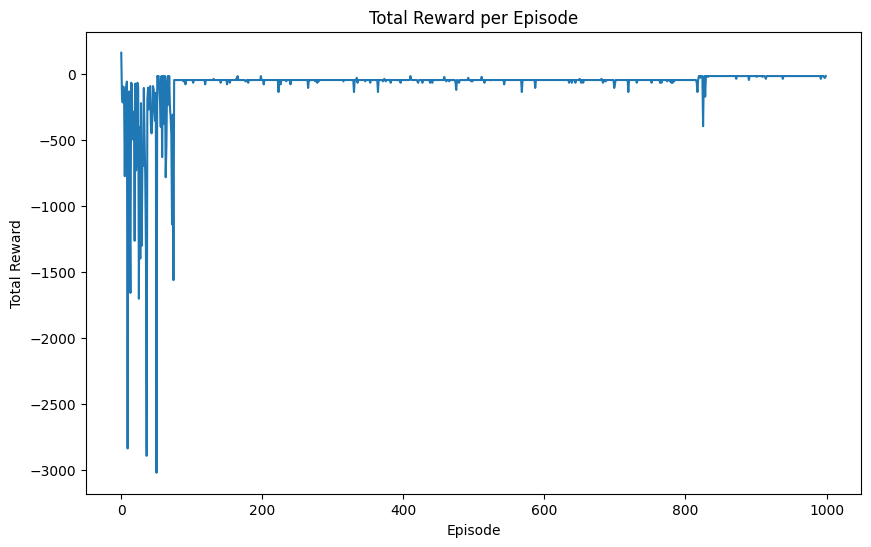

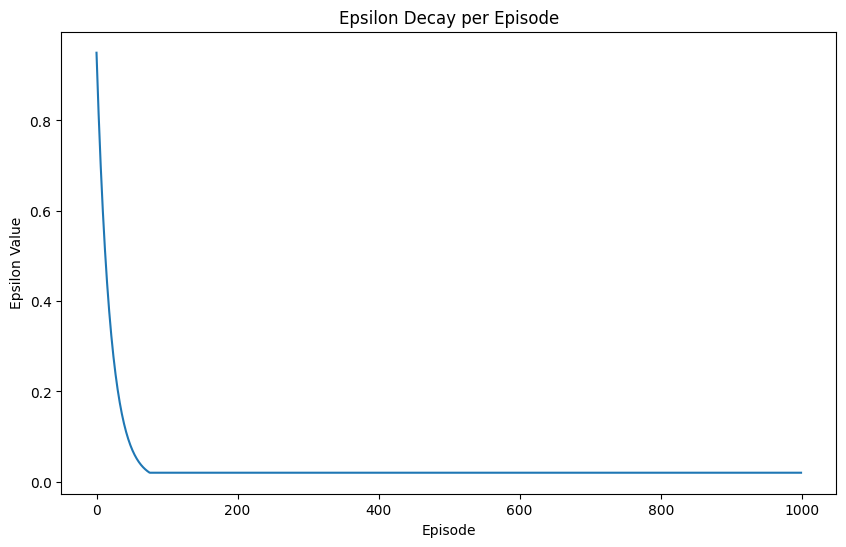

Greedy Episode 1
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(3, 3) Next State: (4, 4)
Total Reward: -15, State:(4, 4) Next State: (5, 5)
Greedy Episode 2
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(3, 3) Next State: (4, 4)
Total Reward: -15, State:(4, 4) Next State: (5, 5)
Greedy Episode 3
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(3, 3) Next State: (4, 4)
Total Reward: -15, State:(4, 4) Next State: (5, 5)
Greedy Episode 4
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(

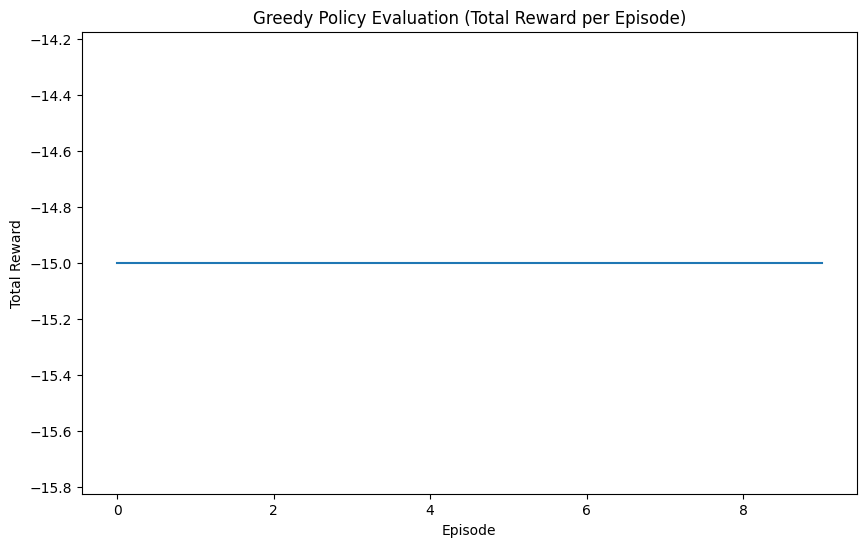

In [66]:
# Running the SARSA approach
env = GridWorld()

# Hyperparameters
episodes = 1000
alpha = 0.222
discount = 0.812
epsilon = 1
epsilon_min = 0.0199
epsilon_decay = 0.95


Q_values, initial_Q_values, total_rewards, epsilon_values = sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay)

# Evaluation and plots
# Convert the Q-table into a DataFrame for better visualization
states = [(i // 6, i % 6) for i in range(env.state_space)]
action_columns = env.action_names
initial_q_table_df = pd.DataFrame(initial_Q_values, index=[f"State {state}" for state in states], columns=action_columns)
final_q_table_df = pd.DataFrame(Q_values, index=[f"State {state}" for state in states], columns=action_columns)
print("Initial Q-table:")
print(initial_q_table_df)
print("\nTrained Q-table after SARSA:")
print(final_q_table_df)

# Plot total reward per episode graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

# Plot epsilon decay graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay per Episode')
plt.show()

## Greedy policy evaluation
greedy_rewards = []
for episode in range(10):
    print(f"Greedy Episode {episode+1}")
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(Q_values[state[0] * 6 + state[1]])  # Choose greedy action
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        print(f"Total Reward: {total_reward}, State:{state} Next State: {next_state}")
        state = next_state

        # Check if the agent has reached the goal state (5,5)
        if state == (5, 5):
            done = True  # Set done to True when the goal state is reached

    greedy_rewards.append(total_reward)

# Plot greedy rewards
plt.figure(figsize=(10, 6))
plt.plot(range(10), greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation (Total Reward per Episode)')
plt.show()

HyperParam Tuning 1 - Number of episodes -Attempt 1

Initial Q-table:
                    Up      Down     Right      Left  Diagonal Down Right
State (0, 0)  0.008733  0.008185  0.009332  0.004461             0.017115
State (0, 1)  0.010016  0.004410  0.015955  0.011857             0.006187
State (0, 2)  0.019056  0.017050  0.008149  0.009474             0.007246
State (0, 3)  0.014880  0.018630  0.014543  0.006565             0.012759
State (0, 4)  0.008432  0.001861  0.013319  0.012669             0.000146
State (0, 5)  0.002952  0.007731  0.017827  0.015424             0.008273
State (1, 0)  0.012111  0.009193  0.005525  0.018685             0.004950
State (1, 1)  0.013144  0.009769  0.000954  0.002059             0.006483
State (1, 2)  0.004070  0.012495  0.014592  0.015812             0.018652
State (1, 3)  0.012213  0.006530  0.014011  0.011353             0.015725
State (1, 4)  0.001962  0.007618  0.008424  0.014047             0.000914
State (1, 5)  0.002850  0.001342  0.015540  0.007964             0.012357
State (2, 0)  0.00204

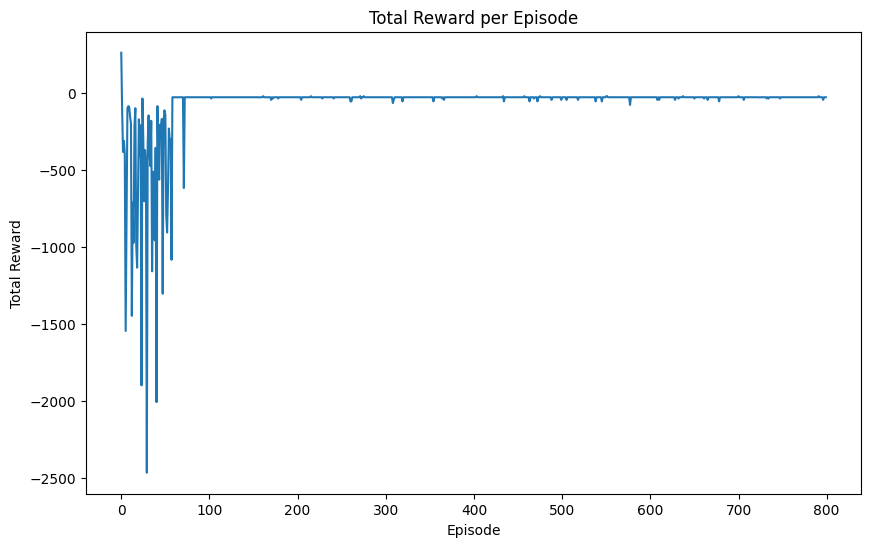

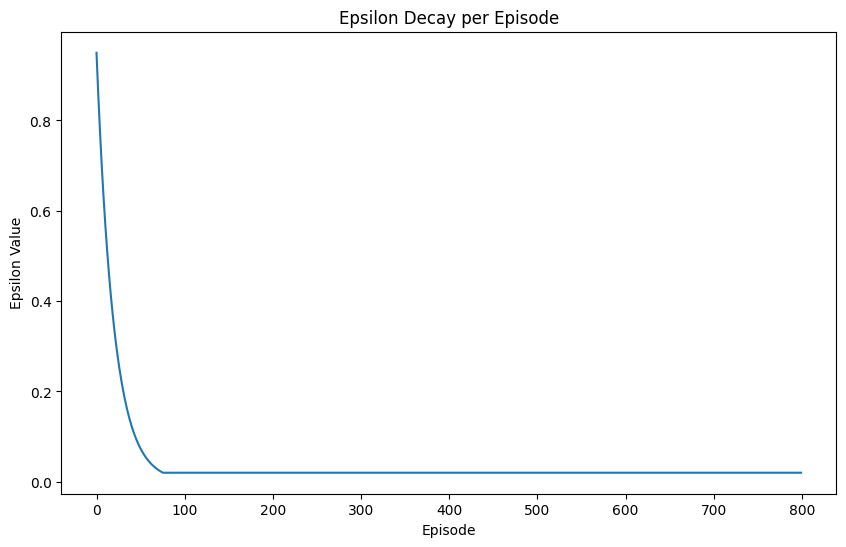

Greedy Episode 1
Total Reward: -1, State:(0, 0) Next State: (0, 1)
Total Reward: -3, State:(0, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (2, 3)
Total Reward: -10, State:(2, 3) Next State: (3, 4)
Total Reward: -15, State:(3, 4) Next State: (3, 3)
Total Reward: -21, State:(3, 3) Next State: (4, 4)
Total Reward: -28, State:(4, 4) Next State: (5, 5)
Greedy Episode 2
Total Reward: -1, State:(0, 0) Next State: (0, 1)
Total Reward: -3, State:(0, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (2, 3)
Total Reward: -10, State:(2, 3) Next State: (3, 4)
Total Reward: -15, State:(3, 4) Next State: (3, 3)
Total Reward: -21, State:(3, 3) Next State: (4, 4)
Total Reward: -28, State:(4, 4) Next State: (5, 5)
Greedy Episode 3
Total Reward: -1, State:(0, 0) Next State: (0, 1)
Total Reward: -3, State:(0, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (2, 3)
Total Reward: -10, State:(2, 3) Next State: (3, 4)
Total Reward: -15, State:(3, 4) Next Sta

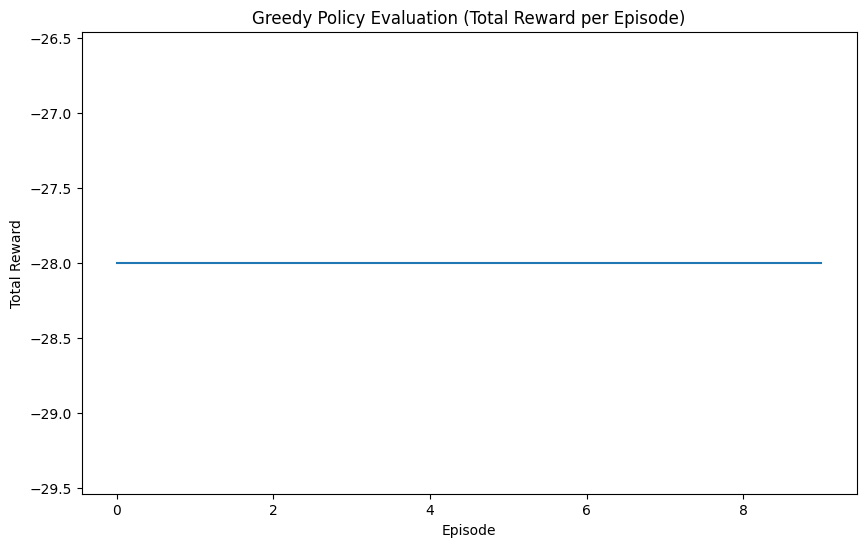

In [67]:
# Running the SARSA approach
env = GridWorld()

# Hyperparameters
episodes = 800
alpha = 0.222
discount = 0.812
epsilon = 1
epsilon_min = 0.0199
epsilon_decay = 0.95


Q_values, initial_Q_values, total_rewards, epsilon_values = sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay)

# Evaluation and plots
# Convert the Q-table into a DataFrame for better visualization
states = [(i // 6, i % 6) for i in range(env.state_space)]
action_columns = env.action_names
initial_q_table_df = pd.DataFrame(initial_Q_values, index=[f"State {state}" for state in states], columns=action_columns)
final_q_table_df = pd.DataFrame(Q_values, index=[f"State {state}" for state in states], columns=action_columns)
print("Initial Q-table:")
print(initial_q_table_df)
print("\nTrained Q-table after SARSA:")
print(final_q_table_df)

# Plot total reward per episode graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

# Plot epsilon decay graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay per Episode')
plt.show()

## Greedy policy evaluation
greedy_rewards = []
for episode in range(10):
    print(f"Greedy Episode {episode+1}")
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(Q_values[state[0] * 6 + state[1]])  # Choose greedy action
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        print(f"Total Reward: {total_reward}, State:{state} Next State: {next_state}")
        state = next_state

        # Check if the agent has reached the goal state (5,5)
        if state == (5, 5):
            done = True  # Set done to True when the goal state is reached

    greedy_rewards.append(total_reward)

# Plot greedy rewards
plt.figure(figsize=(10, 6))
plt.plot(range(10), greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation (Total Reward per Episode)')
plt.show()

Hyperparameter Tuning 1 - Number of episodes -Attempt 2

Initial Q-table:
                    Up      Down     Right      Left  Diagonal Down Right
State (0, 0)  0.019516  0.001460  0.007949  0.019397             0.018589
State (0, 1)  0.002235  0.017432  0.007362  0.013894             0.009521
State (0, 2)  0.014939  0.001243  0.017399  0.011136             0.002603
State (0, 3)  0.005197  0.000849  0.011065  0.001980             0.010804
State (0, 4)  0.018522  0.005143  0.017118  0.015612             0.017373
State (0, 5)  0.016138  0.000942  0.009947  0.000438             0.006313
State (1, 0)  0.012778  0.008115  0.009711  0.011486             0.004501
State (1, 1)  0.014872  0.000995  0.000352  0.019096             0.014718
State (1, 2)  0.002540  0.000572  0.008727  0.013139             0.007615
State (1, 3)  0.019605  0.002158  0.004369  0.019254             0.011595
State (1, 4)  0.013512  0.009890  0.001562  0.016804             0.008465
State (1, 5)  0.002678  0.013834  0.016562  0.013407             0.000278
State (2, 0)  0.01211

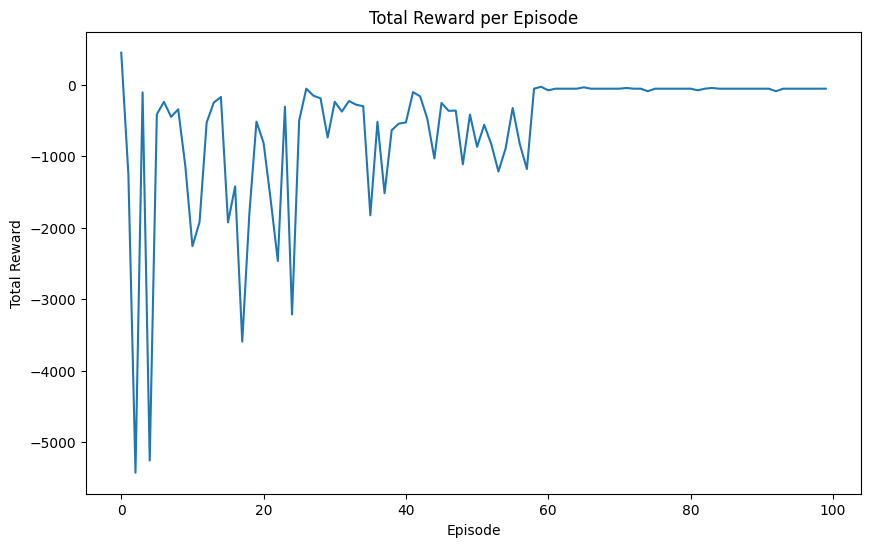

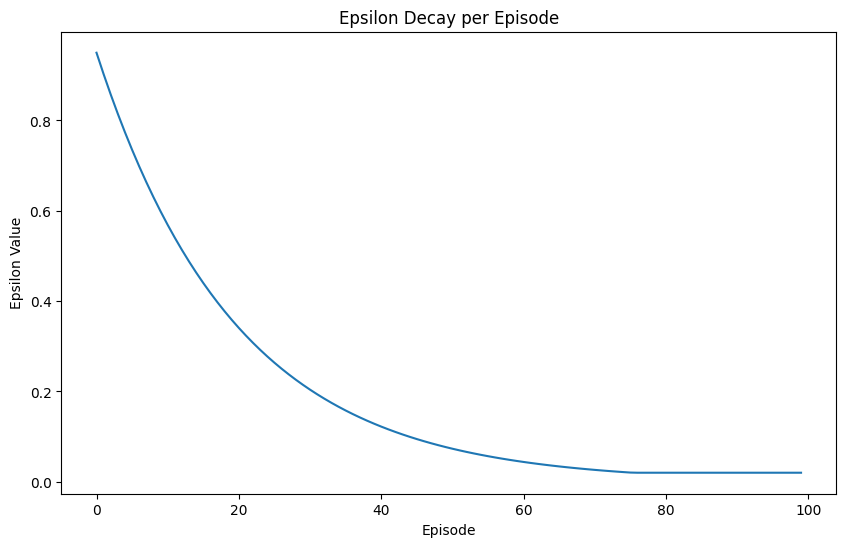

Greedy Episode 1
Total Reward: -1, State:(0, 0) Next State: (1, 0)
Total Reward: -3, State:(1, 0) Next State: (1, 1)
Total Reward: -6, State:(1, 1) Next State: (0, 1)
Total Reward: -10, State:(0, 1) Next State: (0, 2)
Total Reward: -15, State:(0, 2) Next State: (1, 2)
Total Reward: -21, State:(1, 2) Next State: (2, 3)
Total Reward: -28, State:(2, 3) Next State: (2, 2)
Total Reward: -36, State:(2, 2) Next State: (3, 3)
Total Reward: -45, State:(3, 3) Next State: (4, 4)
Total Reward: -55, State:(4, 4) Next State: (5, 5)
Greedy Episode 2
Total Reward: -1, State:(0, 0) Next State: (1, 0)
Total Reward: -3, State:(1, 0) Next State: (1, 1)
Total Reward: -6, State:(1, 1) Next State: (0, 1)
Total Reward: -10, State:(0, 1) Next State: (0, 2)
Total Reward: -15, State:(0, 2) Next State: (1, 2)
Total Reward: -21, State:(1, 2) Next State: (2, 3)
Total Reward: -28, State:(2, 3) Next State: (2, 2)
Total Reward: -36, State:(2, 2) Next State: (3, 3)
Total Reward: -45, State:(3, 3) Next State: (4, 4)
Tot

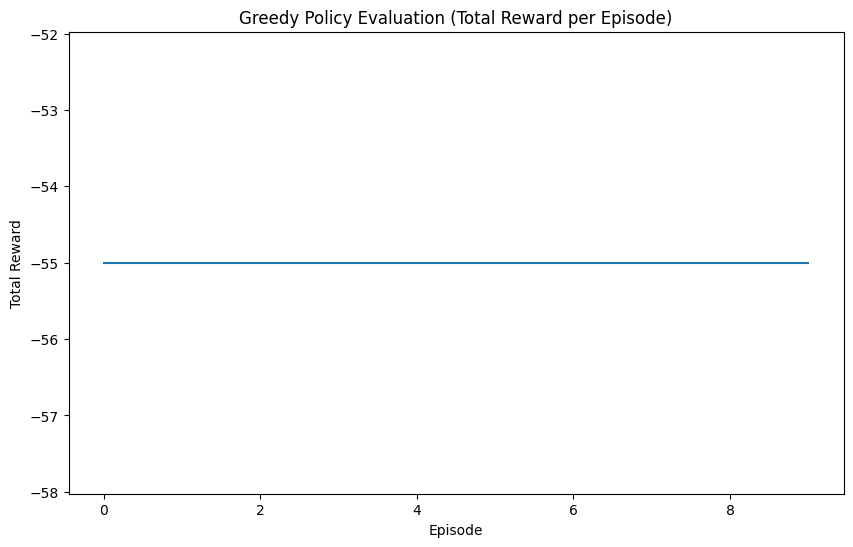

In [68]:
# Running the SARSA approach
env = GridWorld()

# Hyperparameters
episodes = 100
alpha = 0.222
discount = 0.812
epsilon = 1
epsilon_min = 0.0199
epsilon_decay = 0.95


Q_values, initial_Q_values, total_rewards, epsilon_values = sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay)

# Evaluation and plots
# Convert the Q-table into a DataFrame for better visualization
states = [(i // 6, i % 6) for i in range(env.state_space)]
action_columns = env.action_names
initial_q_table_df = pd.DataFrame(initial_Q_values, index=[f"State {state}" for state in states], columns=action_columns)
final_q_table_df = pd.DataFrame(Q_values, index=[f"State {state}" for state in states], columns=action_columns)
print("Initial Q-table:")
print(initial_q_table_df)
print("\nTrained Q-table after SARSA:")
print(final_q_table_df)

# Plot total reward per episode graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

# Plot epsilon decay graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay per Episode')
plt.show()

## Greedy policy evaluation
greedy_rewards = []
for episode in range(10):
    print(f"Greedy Episode {episode+1}")
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(Q_values[state[0] * 6 + state[1]])  # Choose greedy action
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        print(f"Total Reward: {total_reward}, State:{state} Next State: {next_state}")
        state = next_state

        # Check if the agent has reached the goal state (5,5)
        if state == (5, 5):
            done = True  # Set done to True when the goal state is reached

    greedy_rewards.append(total_reward)

# Plot greedy rewards
plt.figure(figsize=(10, 6))
plt.plot(range(10), greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation (Total Reward per Episode)')
plt.show()

Hyperparameter Tuning 1 - Number of episodes -Attempt 3

Initial Q-table:
                    Up      Down     Right      Left  Diagonal Down Right
State (0, 0)  0.010812  0.013867  0.009144  0.006688             0.014678
State (0, 1)  0.018115  0.010339  0.003435  0.016693             0.005416
State (0, 2)  0.010183  0.003989  0.017136  0.007110             0.019654
State (0, 3)  0.009098  0.013529  0.001137  0.011034             0.010826
State (0, 4)  0.014849  0.004814  0.015621  0.016115             0.016516
State (0, 5)  0.013467  0.016896  0.018380  0.011065             0.005150
State (1, 0)  0.009653  0.004506  0.003376  0.008282             0.016650
State (1, 1)  0.004566  0.008640  0.016319  0.011728             0.007368
State (1, 2)  0.010547  0.001260  0.000580  0.017611             0.000217
State (1, 3)  0.001387  0.011161  0.011353  0.008421             0.008748
State (1, 4)  0.014772  0.011513  0.001394  0.011481             0.001862
State (1, 5)  0.008387  0.016567  0.013543  0.011262             0.001235
State (2, 0)  0.00097

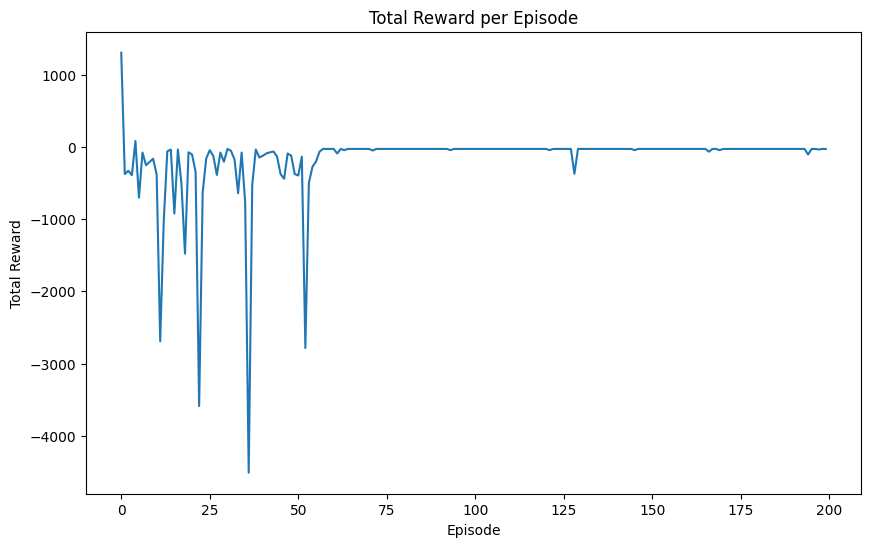

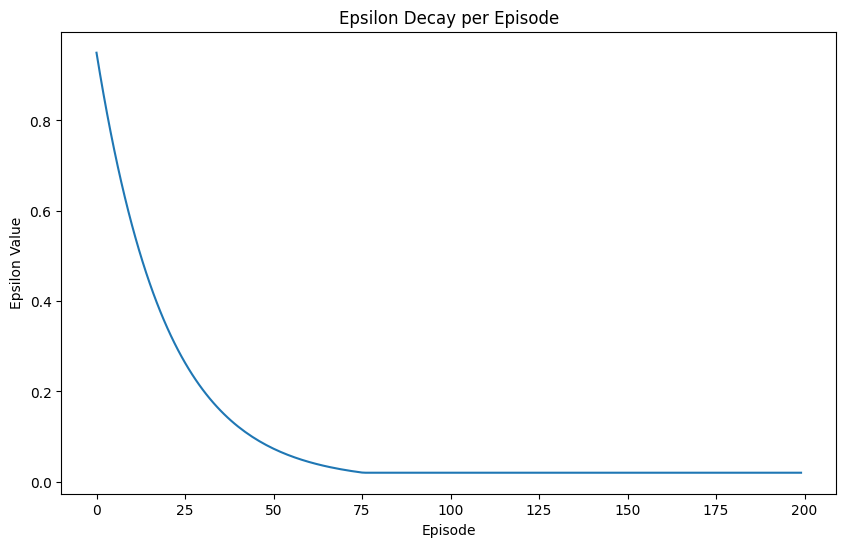

Greedy Episode 1
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 1)
Total Reward: -6, State:(2, 1) Next State: (3, 2)
Total Reward: -10, State:(3, 2) Next State: (3, 3)
Total Reward: -15, State:(3, 3) Next State: (3, 4)
Total Reward: -21, State:(3, 4) Next State: (4, 4)
Total Reward: -28, State:(4, 4) Next State: (5, 5)
Greedy Episode 2
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 1)
Total Reward: -6, State:(2, 1) Next State: (3, 2)
Total Reward: -10, State:(3, 2) Next State: (3, 3)
Total Reward: -15, State:(3, 3) Next State: (3, 4)
Total Reward: -21, State:(3, 4) Next State: (4, 4)
Total Reward: -28, State:(4, 4) Next State: (5, 5)
Greedy Episode 3
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 1)
Total Reward: -6, State:(2, 1) Next State: (3, 2)
Total Reward: -10, State:(3, 2) Next State: (3, 3)
Total Reward: -15, State:(3, 3) Next Sta

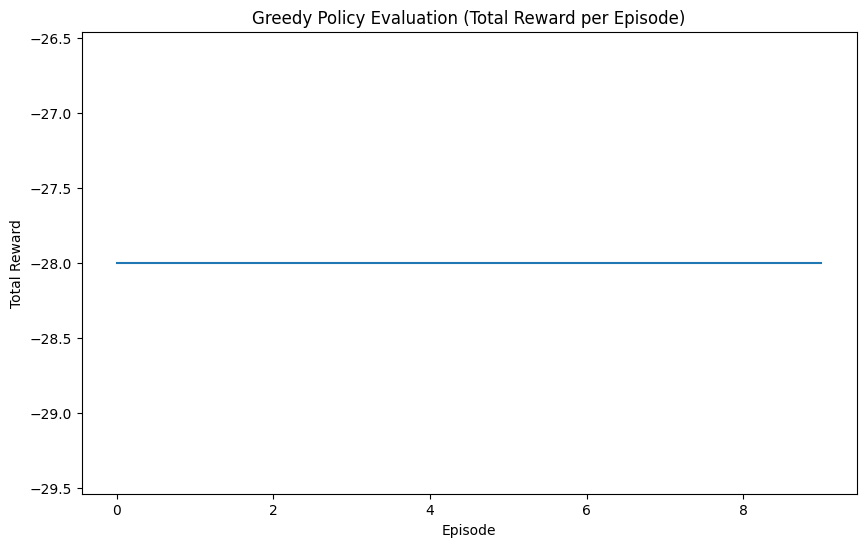

In [69]:
# Running the SARSA approach
env = GridWorld()

# Hyperparameters
episodes = 200
alpha = 0.222
discount = 0.812
epsilon = 1
epsilon_min = 0.0199
epsilon_decay = 0.95


Q_values, initial_Q_values, total_rewards, epsilon_values = sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay)

# Evaluation and plots
# Convert the Q-table into a DataFrame for better visualization
states = [(i // 6, i % 6) for i in range(env.state_space)]
action_columns = env.action_names
initial_q_table_df = pd.DataFrame(initial_Q_values, index=[f"State {state}" for state in states], columns=action_columns)
final_q_table_df = pd.DataFrame(Q_values, index=[f"State {state}" for state in states], columns=action_columns)
print("Initial Q-table:")
print(initial_q_table_df)
print("\nTrained Q-table after SARSA:")
print(final_q_table_df)

# Plot total reward per episode graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

# Plot epsilon decay graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay per Episode')
plt.show()

## Greedy policy evaluation
greedy_rewards = []
for episode in range(10):
    print(f"Greedy Episode {episode+1}")
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(Q_values[state[0] * 6 + state[1]])  # Choose greedy action
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        print(f"Total Reward: {total_reward}, State:{state} Next State: {next_state}")
        state = next_state

        # Check if the agent has reached the goal state (5,5)
        if state == (5, 5):
            done = True  # Set done to True when the goal state is reached

    greedy_rewards.append(total_reward)

# Plot greedy rewards
plt.figure(figsize=(10, 6))
plt.plot(range(10), greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation (Total Reward per Episode)')
plt.show()

Hyperparameter Tuning 2 -Discount Factor -Attempt 1

Initial Q-table:
                    Up      Down     Right      Left  Diagonal Down Right
State (0, 0)  0.000943  0.004487  0.018581  0.018779             0.013855
State (0, 1)  0.004545  0.001742  0.010868  0.000955             0.016080
State (0, 2)  0.010159  0.002082  0.015303  0.002778             0.006811
State (0, 3)  0.010409  0.014757  0.010793  0.018918             0.005610
State (0, 4)  0.019133  0.018232  0.003655  0.015268             0.007728
State (0, 5)  0.003130  0.000768  0.019623  0.011632             0.017232
State (1, 0)  0.006140  0.013358  0.002135  0.006738             0.016177
State (1, 1)  0.006198  0.014741  0.009928  0.015726             0.010427
State (1, 2)  0.002354  0.002222  0.010677  0.009307             0.011141
State (1, 3)  0.000802  0.019929  0.014539  0.000221             0.017000
State (1, 4)  0.017856  0.011439  0.001406  0.011019             0.019899
State (1, 5)  0.005118  0.017435  0.019165  0.018477             0.001753
State (2, 0)  0.00215

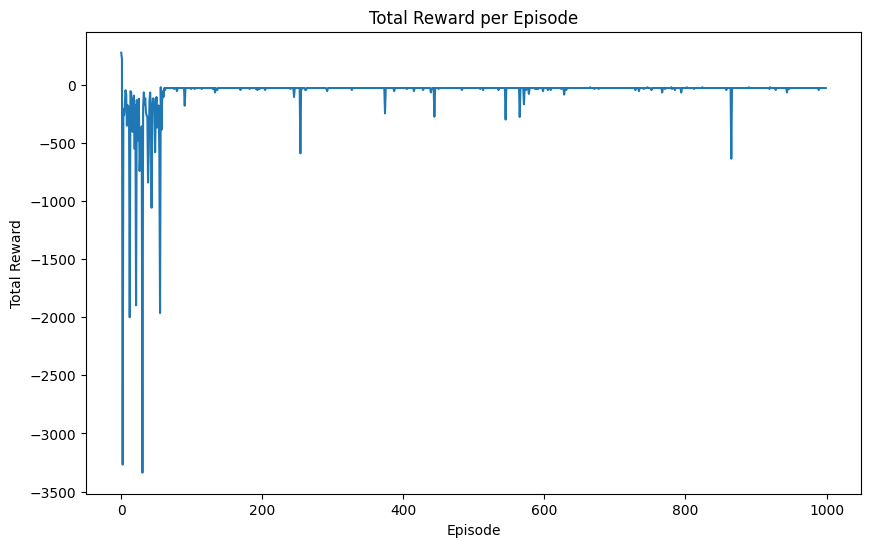

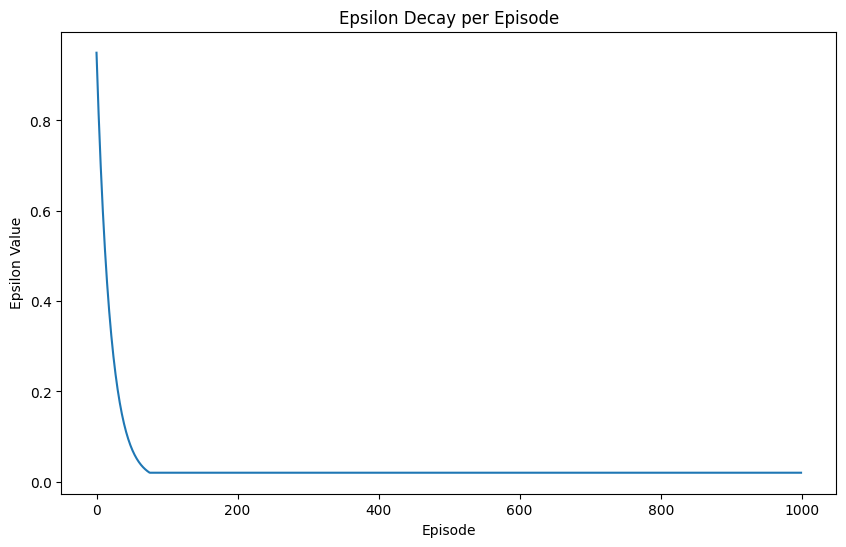

Greedy Episode 1
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (1, 3)
Total Reward: -10, State:(1, 3) Next State: (2, 4)
Total Reward: -15, State:(2, 4) Next State: (3, 4)
Total Reward: -21, State:(3, 4) Next State: (4, 4)
Total Reward: -28, State:(4, 4) Next State: (5, 5)
Greedy Episode 2
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (1, 3)
Total Reward: -10, State:(1, 3) Next State: (2, 4)
Total Reward: -15, State:(2, 4) Next State: (3, 4)
Total Reward: -21, State:(3, 4) Next State: (4, 4)
Total Reward: -28, State:(4, 4) Next State: (5, 5)
Greedy Episode 3
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (1, 3)
Total Reward: -10, State:(1, 3) Next State: (2, 4)
Total Reward: -15, State:(2, 4) Next Sta

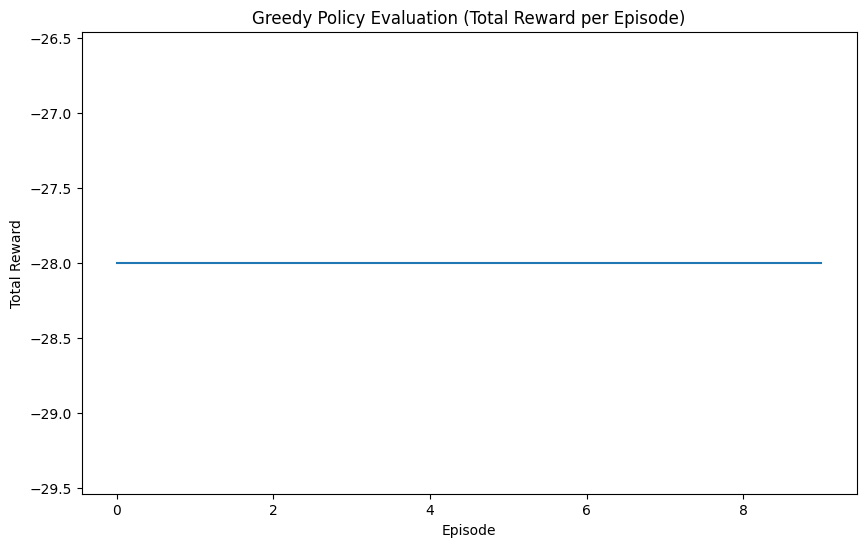

In [70]:
# Running the SARSA approach
env = GridWorld()

# Hyperparameters
episodes = 1000
alpha = 0.222
discount = 0.85
epsilon = 1
epsilon_min = 0.0199
epsilon_decay = 0.95


Q_values, initial_Q_values, total_rewards, epsilon_values = sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay)

# Evaluation and plots
# Convert the Q-table into a DataFrame for better visualization
states = [(i // 6, i % 6) for i in range(env.state_space)]
action_columns = env.action_names
initial_q_table_df = pd.DataFrame(initial_Q_values, index=[f"State {state}" for state in states], columns=action_columns)
final_q_table_df = pd.DataFrame(Q_values, index=[f"State {state}" for state in states], columns=action_columns)
print("Initial Q-table:")
print(initial_q_table_df)
print("\nTrained Q-table after SARSA:")
print(final_q_table_df)

# Plot total reward per episode graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

# Plot epsilon decay graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay per Episode')
plt.show()

## Greedy policy evaluation
greedy_rewards = []
for episode in range(10):
    print(f"Greedy Episode {episode+1}")
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(Q_values[state[0] * 6 + state[1]])  # Choose greedy action
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        print(f"Total Reward: {total_reward}, State:{state} Next State: {next_state}")
        state = next_state

        # Check if the agent has reached the goal state (5,5)
        if state == (5, 5):
            done = True  # Set done to True when the goal state is reached

    greedy_rewards.append(total_reward)

# Plot greedy rewards
plt.figure(figsize=(10, 6))
plt.plot(range(10), greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation (Total Reward per Episode)')
plt.show()

Hyperparameter Tuning 2 -Discount Factor -Attempt 2

Initial Q-table:
                    Up      Down     Right      Left  Diagonal Down Right
State (0, 0)  0.004537  0.017744  0.016080  0.001352             0.010462
State (0, 1)  0.017774  0.013803  0.018968  0.019929             0.019078
State (0, 2)  0.000516  0.011163  0.015709  0.006265             0.005656
State (0, 3)  0.019154  0.007312  0.017560  0.003619             0.013342
State (0, 4)  0.019581  0.012560  0.017333  0.015221             0.000234
State (0, 5)  0.007349  0.014428  0.010859  0.013471             0.011843
State (1, 0)  0.000354  0.002372  0.015582  0.018049             0.008704
State (1, 1)  0.017726  0.019351  0.015494  0.006328             0.019671
State (1, 2)  0.011234  0.010514  0.018643  0.016752             0.005087
State (1, 3)  0.003691  0.015111  0.000382  0.013923             0.018028
State (1, 4)  0.019579  0.015396  0.008532  0.019053             0.015640
State (1, 5)  0.017709  0.000159  0.007572  0.018163             0.015541
State (2, 0)  0.00273

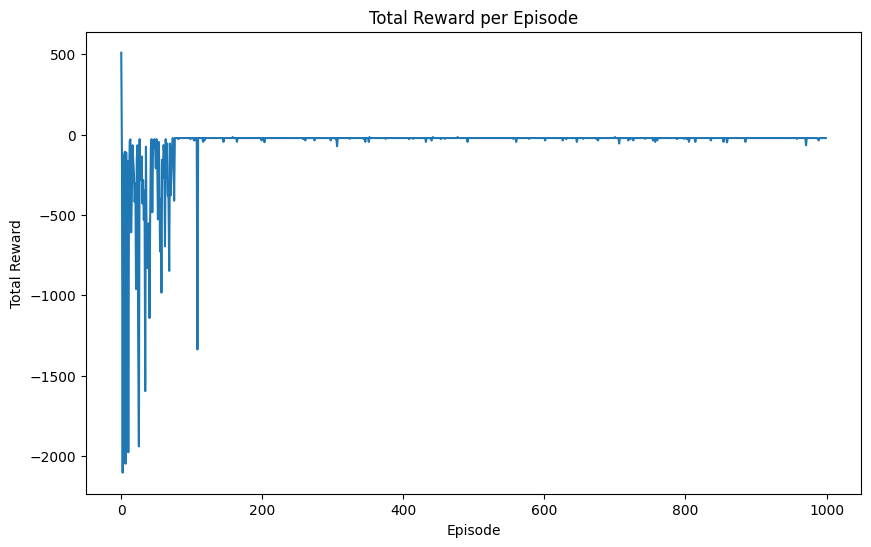

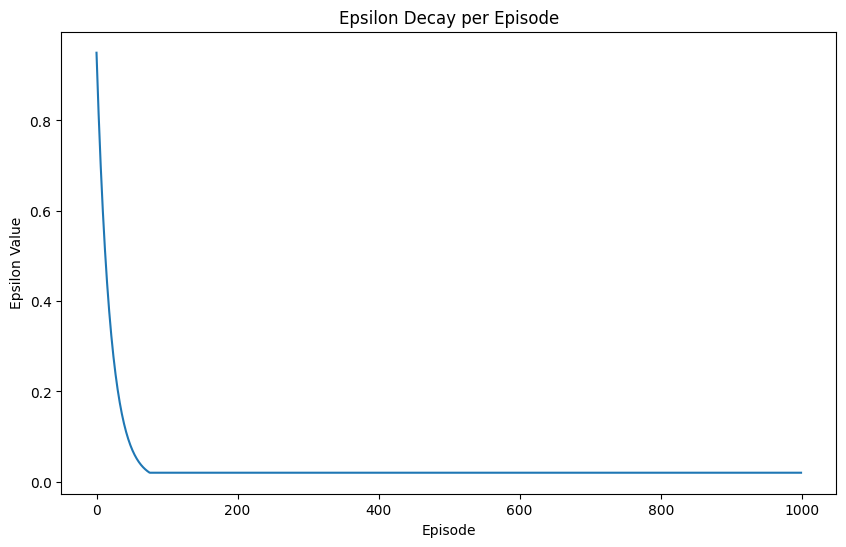

Greedy Episode 1
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (2, 3)
Total Reward: -10, State:(2, 3) Next State: (3, 4)
Total Reward: -15, State:(3, 4) Next State: (4, 5)
Total Reward: -21, State:(4, 5) Next State: (5, 5)
Greedy Episode 2
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (2, 3)
Total Reward: -10, State:(2, 3) Next State: (3, 4)
Total Reward: -15, State:(3, 4) Next State: (4, 5)
Total Reward: -21, State:(4, 5) Next State: (5, 5)
Greedy Episode 3
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (2, 3)
Total Reward: -10, State:(2, 3) Next State: (3, 4)
Total Reward: -15, State:(3, 4) Next State: (4, 5)
Total Reward: -21, State:(4, 5) Next State: (5, 5)
Greedy Episode 4
Total Reward: -1, State

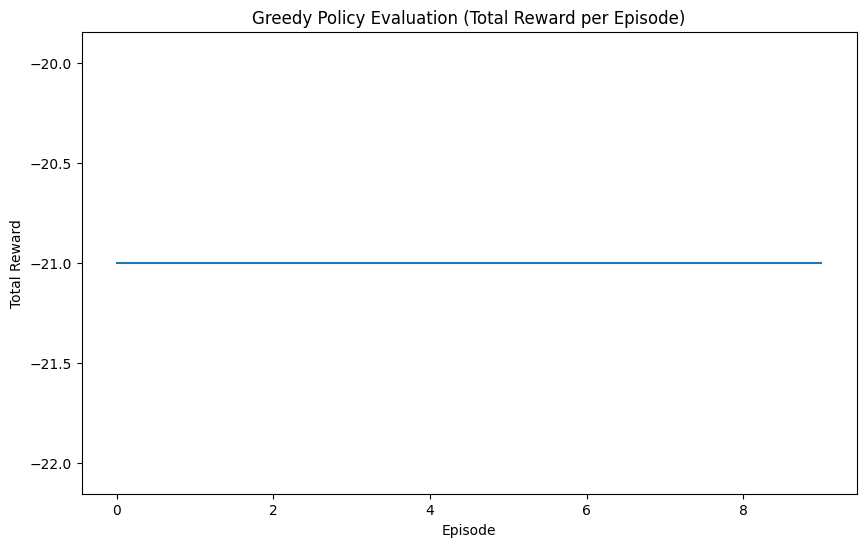

In [71]:
# Running the SARSA approach
env = GridWorld()

# Hyperparameters
episodes = 1000
alpha = 0.222
discount = 0.90
epsilon = 1
epsilon_min = 0.0199
epsilon_decay = 0.95


Q_values, initial_Q_values, total_rewards, epsilon_values = sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay)

# Evaluation and plots
# Convert the Q-table into a DataFrame for better visualization
states = [(i // 6, i % 6) for i in range(env.state_space)]
action_columns = env.action_names
initial_q_table_df = pd.DataFrame(initial_Q_values, index=[f"State {state}" for state in states], columns=action_columns)
final_q_table_df = pd.DataFrame(Q_values, index=[f"State {state}" for state in states], columns=action_columns)
print("Initial Q-table:")
print(initial_q_table_df)
print("\nTrained Q-table after SARSA:")
print(final_q_table_df)

# Plot total reward per episode graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

# Plot epsilon decay graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay per Episode')
plt.show()

## Greedy policy evaluation
greedy_rewards = []
for episode in range(10):
    print(f"Greedy Episode {episode+1}")
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(Q_values[state[0] * 6 + state[1]])  # Choose greedy action
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        print(f"Total Reward: {total_reward}, State:{state} Next State: {next_state}")
        state = next_state

        # Check if the agent has reached the goal state (5,5)
        if state == (5, 5):
            done = True  # Set done to True when the goal state is reached

    greedy_rewards.append(total_reward)

# Plot greedy rewards
plt.figure(figsize=(10, 6))
plt.plot(range(10), greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation (Total Reward per Episode)')
plt.show()

Hyperparameter Tuning 2 -Discount Factor -Attempt 3

Initial Q-table:
                    Up      Down     Right      Left  Diagonal Down Right
State (0, 0)  0.019305  0.000674  0.006434  0.005434             0.008648
State (0, 1)  0.007250  0.009568  0.008278  0.017454             0.018753
State (0, 2)  0.012461  0.018048  0.009011  0.016797             0.017886
State (0, 3)  0.017195  0.007159  0.013839  0.011772             0.007748
State (0, 4)  0.015025  0.015613  0.014078  0.007723             0.009805
State (0, 5)  0.002283  0.008361  0.014373  0.017129             0.019348
State (1, 0)  0.003409  0.008212  0.003952  0.011092             0.004234
State (1, 1)  0.003007  0.006129  0.001749  0.012704             0.006204
State (1, 2)  0.015326  0.012269  0.017119  0.009628             0.006969
State (1, 3)  0.007530  0.004339  0.012621  0.006863             0.014544
State (1, 4)  0.010050  0.011906  0.018310  0.013523             0.009377
State (1, 5)  0.003865  0.014299  0.002883  0.009565             0.009520
State (2, 0)  0.00573

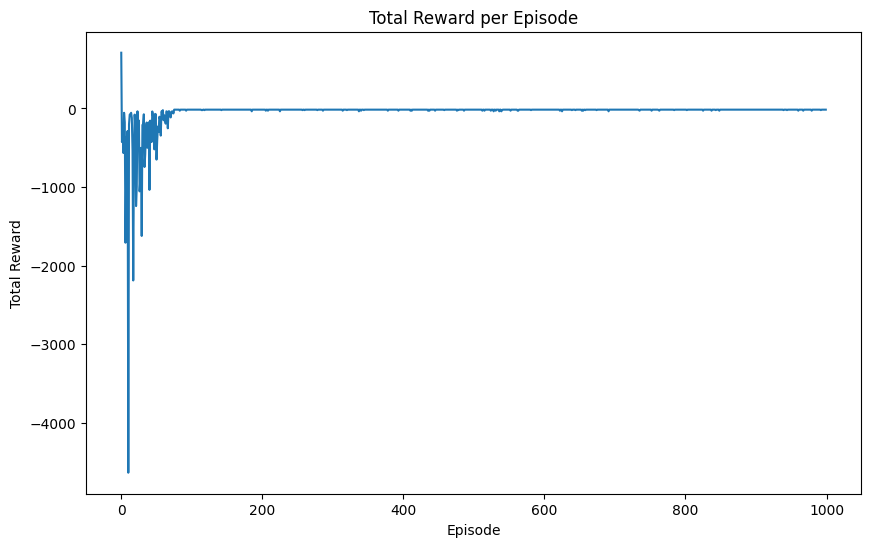

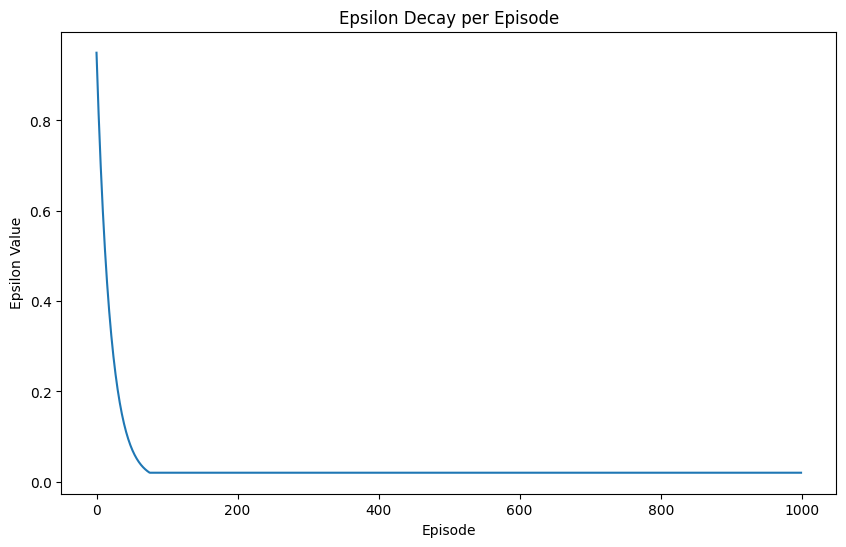

Greedy Episode 1
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(3, 3) Next State: (4, 4)
Total Reward: -15, State:(4, 4) Next State: (5, 5)
Greedy Episode 2
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(3, 3) Next State: (4, 4)
Total Reward: -15, State:(4, 4) Next State: (5, 5)
Greedy Episode 3
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(3, 3) Next State: (4, 4)
Total Reward: -15, State:(4, 4) Next State: (5, 5)
Greedy Episode 4
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(

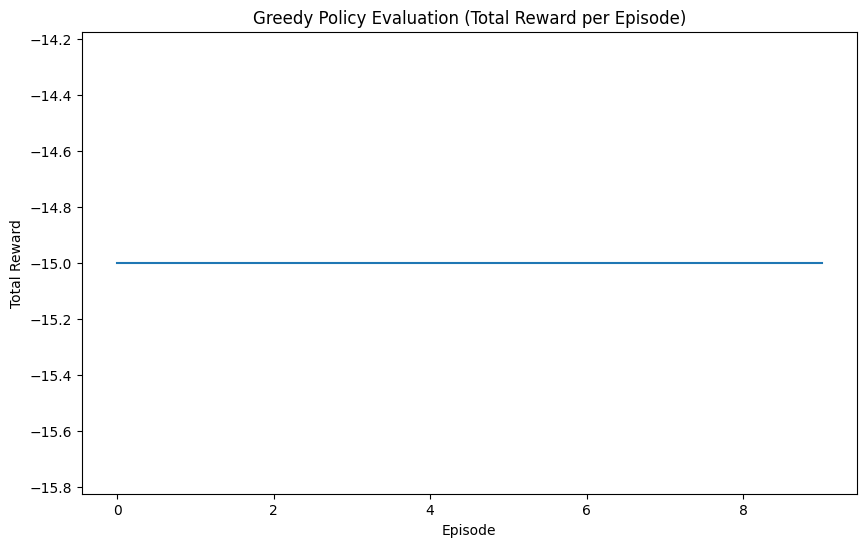

In [72]:
# Running the SARSA approach
env = GridWorld()

# Hyperparameters
episodes = 1000
alpha = 0.222
discount = 0.999
epsilon = 1
epsilon_min = 0.0199
epsilon_decay = 0.95


Q_values, initial_Q_values, total_rewards, epsilon_values = sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay)

# Evaluation and plots
# Convert the Q-table into a DataFrame for better visualization
states = [(i // 6, i % 6) for i in range(env.state_space)]
action_columns = env.action_names
initial_q_table_df = pd.DataFrame(initial_Q_values, index=[f"State {state}" for state in states], columns=action_columns)
final_q_table_df = pd.DataFrame(Q_values, index=[f"State {state}" for state in states], columns=action_columns)
print("Initial Q-table:")
print(initial_q_table_df)
print("\nTrained Q-table after SARSA:")
print(final_q_table_df)

# Plot total reward per episode graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

# Plot epsilon decay graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay per Episode')
plt.show()

## Greedy policy evaluation
greedy_rewards = []
for episode in range(10):
    print(f"Greedy Episode {episode+1}")
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(Q_values[state[0] * 6 + state[1]])  # Choose greedy action
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        print(f"Total Reward: {total_reward}, State:{state} Next State: {next_state}")
        state = next_state

        # Check if the agent has reached the goal state (5,5)
        if state == (5, 5):
            done = True  # Set done to True when the goal state is reached

    greedy_rewards.append(total_reward)

# Plot greedy rewards
plt.figure(figsize=(10, 6))
plt.plot(range(10), greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation (Total Reward per Episode)')
plt.show()

Trying optuna

In [26]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00


In [73]:
import optuna

In [76]:

def sarsaOptuna(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay):
    Q = np.random.uniform(low=0.00, high=0.02, size=(env.state_space, env.action_space.n))
    Q[5 * 6 + 5, :] = 0

    total_rewards = []
    epsilon_values = []

    for episode in range(episodes):
        state = env.reset()
        action = epsilon_greedy(Q, state, epsilon, env.action_space.n)

        total_reward = 0
        done = False

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon, env.action_space.n)

            if next_state != (5, 5):
                Q[state[0] * 6 + state[1], action] += alpha * (reward + discount * Q[next_state[0] * 6 + next_state[1], next_action] - Q[state[0] * 6 + state[1], action])

            state, action = next_state, next_action
            total_reward += reward

        Q[5 * 6 + 5, :] = 0

        total_rewards.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)
    #the mean of total rewards for optimization
    return np.mean(total_rewards)

# Define the objective function for Optuna
def objective(trial):
    alpha = trial.suggest_float("alpha", 0.01, 0.5)
    discount = trial.suggest_float("discount", 0.8, 1.0)
    epsilon = trial.suggest_float("epsilon", 0.01, 1.0)
    epsilon_min = trial.suggest_float("epsilon_min", 0.01, 0.1)
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.9, 0.999)

    env = GridWorld()
    episodes = 1000
    mean_of_reward = sarsaOptuna(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay)

    return mean_of_reward

#Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)


# Show optimization results
print("Best Hyperparameters:")
print(study.best_params)
print(f"Best trial: {study.best_trial.value}")
print("Trial details:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")



[I 2024-11-21 22:13:48,001] A new study created in memory with name: no-name-83545521-fc23-4e27-9e19-291df2cd6fce
[I 2024-11-21 22:13:48,147] Trial 0 finished with value: -166.587 and parameters: {'alpha': 0.02643212262792141, 'discount': 0.9711233991632235, 'epsilon': 0.4530391215838926, 'epsilon_min': 0.010586308449402282, 'epsilon_decay': 0.9930828679288786}. Best is trial 0 with value: -166.587.
[I 2024-11-21 22:13:48,236] Trial 1 finished with value: -73.87 and parameters: {'alpha': 0.12049750767447776, 'discount': 0.9131526577761643, 'epsilon': 0.04542793755889184, 'epsilon_min': 0.06771634550349288, 'epsilon_decay': 0.9119372303613389}. Best is trial 1 with value: -73.87.
[I 2024-11-21 22:13:48,611] Trial 2 finished with value: -76.077 and parameters: {'alpha': 0.21274353547073108, 'discount': 0.8170989949548837, 'epsilon': 0.9342568732007004, 'epsilon_min': 0.02759808669702843, 'epsilon_decay': 0.9051122908671654}. Best is trial 1 with value: -73.87.
[I 2024-11-21 22:13:48,661]

Best Hyperparameters:
{'alpha': 0.40033038096650403, 'discount': 0.9967338267034774, 'epsilon': 0.14108218644850729, 'epsilon_min': 0.01177471157300046, 'epsilon_decay': 0.9116096939659905}
Best trial: -26.348
Trial details:
alpha: 0.40033038096650403
discount: 0.9967338267034774
epsilon: 0.14108218644850729
epsilon_min: 0.01177471157300046
epsilon_decay: 0.9116096939659905


Running SARSA with Optuna best hyperparams

Initial Q-table With Optuna Optimization:
                    Up      Down     Right      Left  Diagonal Down Right
State (0, 0)  0.010599  0.004706  0.002391  0.000562             0.015191
State (0, 1)  0.010405  0.019135  0.014009  0.015543             0.002310
State (0, 2)  0.013712  0.001802  0.011026  0.006669             0.000094
State (0, 3)  0.000413  0.012525  0.018622  0.010596             0.001712
State (0, 4)  0.014746  0.018003  0.007144  0.010757             0.007921
State (0, 5)  0.006084  0.013239  0.006960  0.003816             0.010199
State (1, 0)  0.004429  0.019428  0.001919  0.013059             0.001347
State (1, 1)  0.013890  0.017850  0.000941  0.018528             0.018167
State (1, 2)  0.017548  0.015658  0.018507  0.002828             0.006216
State (1, 3)  0.006055  0.009733  0.004887  0.018409             0.002016
State (1, 4)  0.019475  0.013231  0.006608  0.006276             0.004484
State (1, 5)  0.016212  0.008030  0.007110  0.007429             0.010

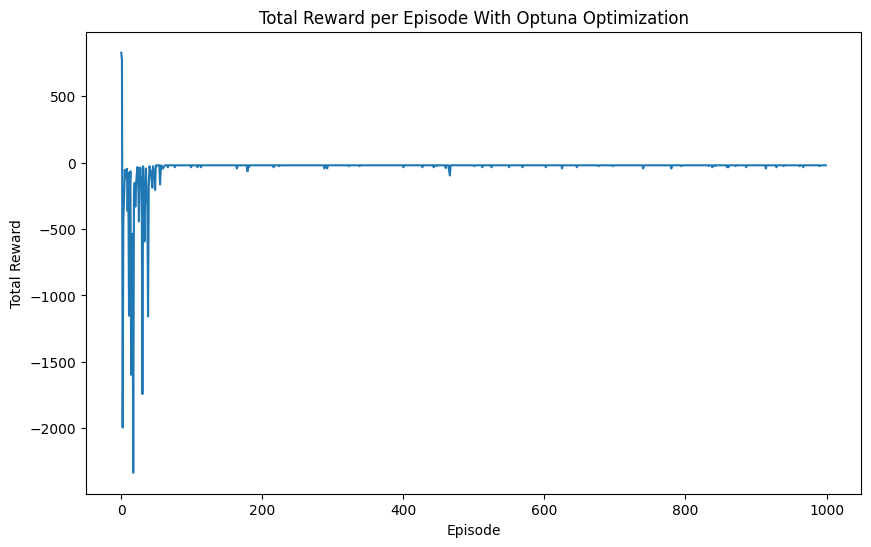

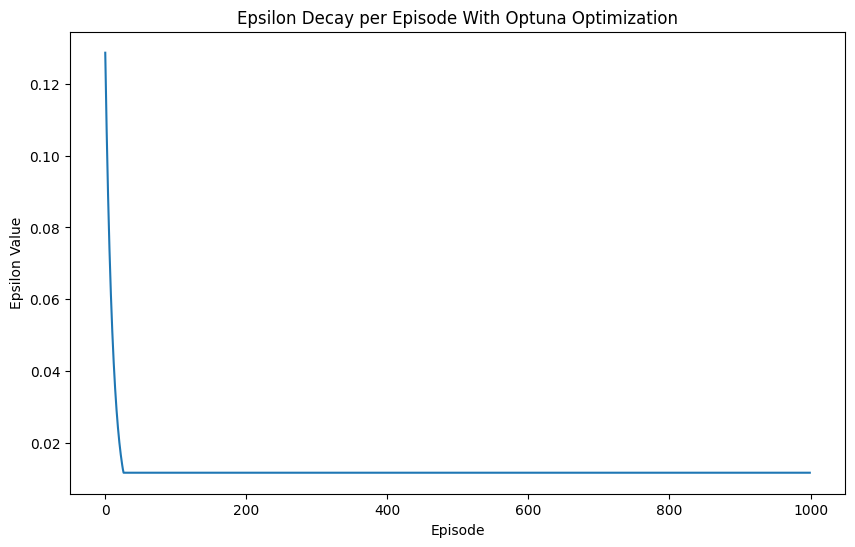

Greedy Episode 1 With Optuna Optimization
Total Reward: -1, State:(0, 0) Next State: (0, 1)
Total Reward: -3, State:(0, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (2, 3)
Total Reward: -10, State:(2, 3) Next State: (3, 3)
Total Reward: -15, State:(3, 3) Next State: (4, 4)
Total Reward: -21, State:(4, 4) Next State: (5, 5)
Greedy Episode 2 With Optuna Optimization
Total Reward: -1, State:(0, 0) Next State: (0, 1)
Total Reward: -3, State:(0, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (2, 3)
Total Reward: -10, State:(2, 3) Next State: (3, 3)
Total Reward: -15, State:(3, 3) Next State: (4, 4)
Total Reward: -21, State:(4, 4) Next State: (5, 5)
Greedy Episode 3 With Optuna Optimization
Total Reward: -1, State:(0, 0) Next State: (0, 1)
Total Reward: -3, State:(0, 1) Next State: (1, 2)
Total Reward: -6, State:(1, 2) Next State: (2, 3)
Total Reward: -10, State:(2, 3) Next State: (3, 3)
Total Reward: -15, State:(3, 3) Next State: (4, 4)
Total Reward: -2

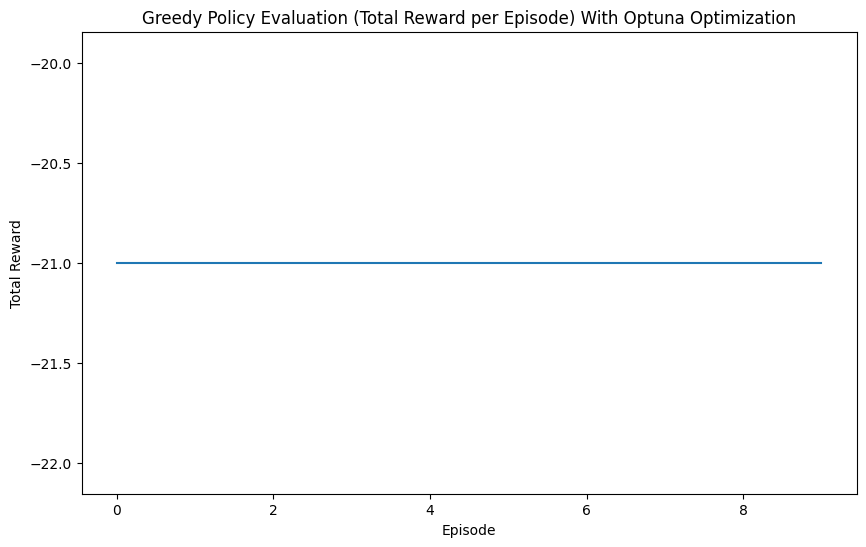

In [78]:
# Running the SARSA approach
env = GridWorld()

# Hyperparameters
episodes = 1000
alpha = 0.40033038096650403
discount = 0.9967338267034774
epsilon = 0.14108218644850729
epsilon_min = 0.01177471157300046
epsilon_decay = 0.9116096939659905


Q_values, initial_Q_values, total_rewards, epsilon_values = sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay)

# Evaluation and plots
# Convert the Q-table into a DataFrame for better visualization
states = [(i // 6, i % 6) for i in range(env.state_space)]
action_columns = env.action_names
initial_q_table_df = pd.DataFrame(initial_Q_values, index=[f"State {state}" for state in states], columns=action_columns)
final_q_table_df = pd.DataFrame(Q_values, index=[f"State {state}" for state in states], columns=action_columns)
print("Initial Q-table With Optuna Optimization:")
print(initial_q_table_df)
print("\nTrained Q-table after SARSA with Optuna Optimization:")
print(final_q_table_df)

# Plot total reward per episode graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode With Optuna Optimization')
plt.show()

# Plot epsilon decay graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay per Episode With Optuna Optimization')
plt.show()

## Greedy policy evaluation
greedy_rewards = []
for episode in range(10):
    print(f"Greedy Episode {episode+1} With Optuna Optimization")
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(Q_values[state[0] * 6 + state[1]])  # Choose greedy action
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        print(f"Total Reward: {total_reward}, State:{state} Next State: {next_state}")
        state = next_state

        # Check if the agent has reached the goal state (5,5)
        if state == (5, 5):
            done = True  # Set done to True when the goal state is reached

    greedy_rewards.append(total_reward)

# Plot greedy rewards
plt.figure(figsize=(10, 6))
plt.plot(range(10), greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation (Total Reward per Episode) With Optuna Optimization')
plt.show()

Best Model

Initial Q-table:
                    Up      Down     Right      Left  Diagonal Down Right
State (0, 0)  0.015857  0.001941  0.015392  0.013945             0.008442
State (0, 1)  0.009129  0.014458  0.006124  0.015439             0.004071
State (0, 2)  0.008082  0.018541  0.018625  0.011184             0.011811
State (0, 3)  0.014270  0.018644  0.013807  0.009952             0.001752
State (0, 4)  0.018578  0.000178  0.007321  0.007902             0.007730
State (0, 5)  0.018607  0.002645  0.005491  0.012240             0.008322
State (1, 0)  0.000305  0.005987  0.017971  0.006641             0.018411
State (1, 1)  0.002656  0.013244  0.018585  0.009032             0.016740
State (1, 2)  0.000860  0.008036  0.016289  0.002491             0.007428
State (1, 3)  0.012489  0.004587  0.001180  0.012384             0.012016
State (1, 4)  0.005436  0.013887  0.005427  0.013485             0.017269
State (1, 5)  0.013250  0.002351  0.014304  0.010451             0.016800
State (2, 0)  0.01191

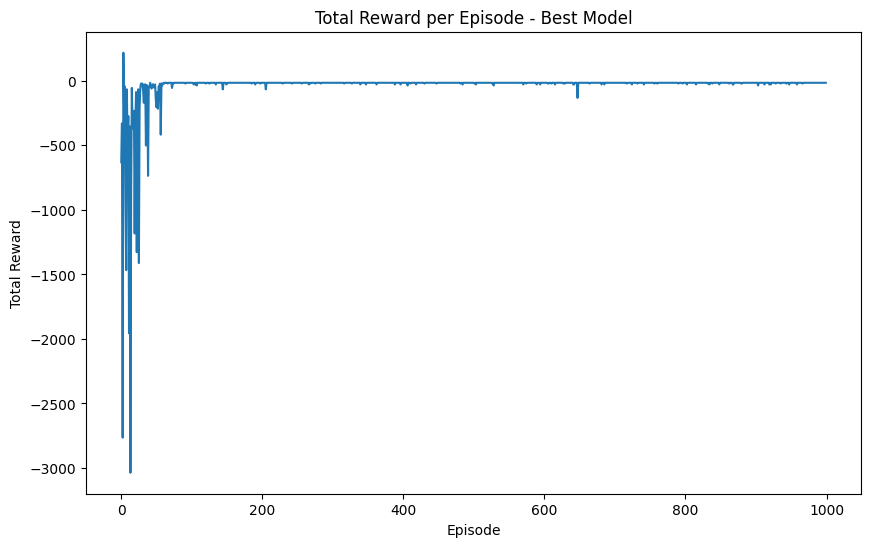

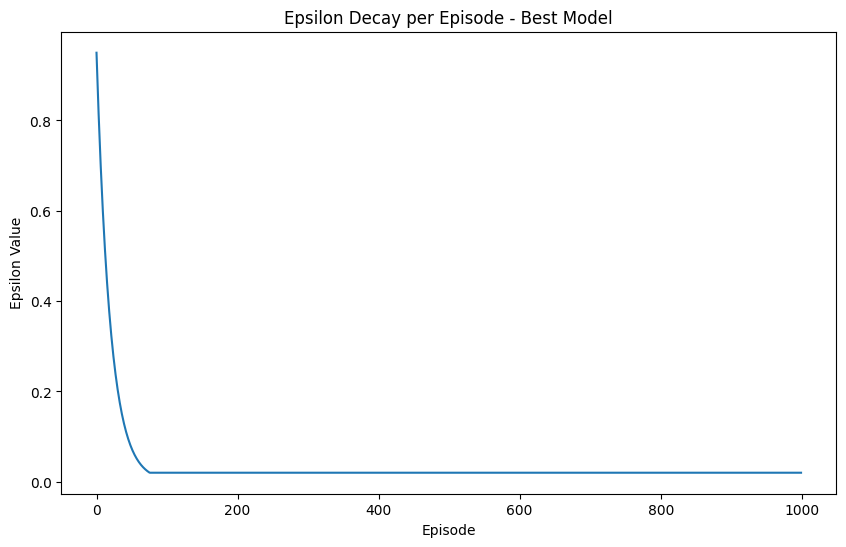

Greedy Episode 1
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(3, 3) Next State: (4, 4)
Total Reward: -15, State:(4, 4) Next State: (5, 5)
Greedy Episode 2
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(3, 3) Next State: (4, 4)
Total Reward: -15, State:(4, 4) Next State: (5, 5)
Greedy Episode 3
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(3, 3) Next State: (4, 4)
Total Reward: -15, State:(4, 4) Next State: (5, 5)
Greedy Episode 4
Total Reward: -1, State:(0, 0) Next State: (1, 1)
Total Reward: -3, State:(1, 1) Next State: (2, 2)
Total Reward: -6, State:(2, 2) Next State: (3, 3)
Total Reward: -10, State:(

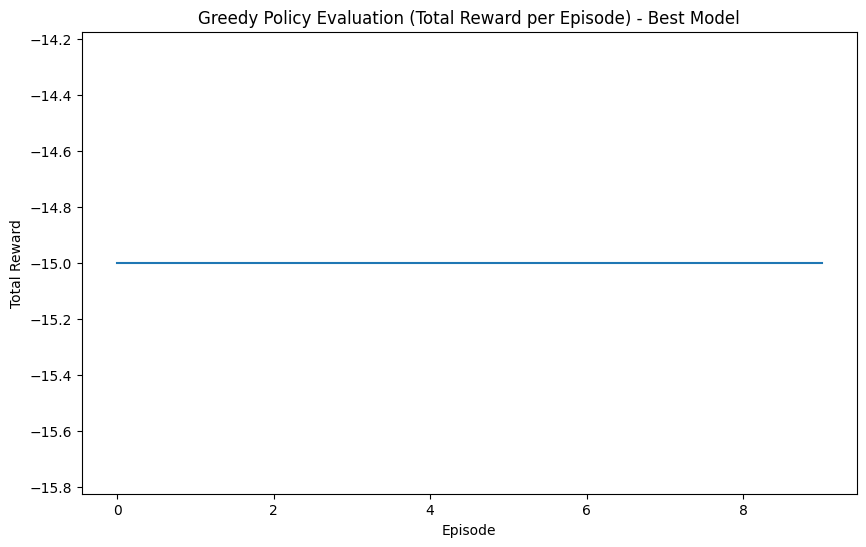

In [81]:
# Running the SARSA approach
env = GridWorld()

# Hyperparameters
episodes = 1000
alpha = 0.222
discount = 0.999
epsilon = 1
epsilon_min = 0.0199
epsilon_decay = 0.95


Q_values, initial_Q_values, total_rewards, epsilon_values = sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay)

# Evaluation and plots
# Convert the Q-table into a DataFrame for better visualization
states = [(i // 6, i % 6) for i in range(env.state_space)]
action_columns = env.action_names
initial_q_table_df = pd.DataFrame(initial_Q_values, index=[f"State {state}" for state in states], columns=action_columns)
final_q_table_df = pd.DataFrame(Q_values, index=[f"State {state}" for state in states], columns=action_columns)
print("Initial Q-table:")
print(initial_q_table_df)
print("\nTrained Q-table after SARSA:")
print(final_q_table_df)

# Plot total reward per episode graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode - Best Model')
plt.show()

# Plot epsilon decay graph
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay per Episode - Best Model')
plt.show()

## Greedy policy evaluation
greedy_rewards = []
for episode in range(10):
    print(f"Greedy Episode {episode+1}")
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(Q_values[state[0] * 6 + state[1]])  # Choose greedy action
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        print(f"Total Reward: {total_reward}, State:{state} Next State: {next_state}")
        state = next_state

        # Check if the agent has reached the goal state (5,5)
        if state == (5, 5):
            done = True  # Set done to True when the goal state is reached

    greedy_rewards.append(total_reward)

# Plot greedy rewards
plt.figure(figsize=(10, 6))
plt.plot(range(10), greedy_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation (Total Reward per Episode) - Best Model')
plt.show()